In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, TimeDistributed, Dense
import keras.backend as K

c:\users\troy\anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
samples = 100

def f_gen(start=None):
    if start == None:
        x = np.random.rand()*np.pi*2
    else:
        x = start*np.pi*2
    step = np.pi*2/samples
    while True:
        y = np.sin(x)
        y = np.maximum(y**3, 0)
        r = np.random.rand()*2-1
        y = y + r*(1-y**2)*np.sin(x)*0.5
        x += step
        yield y

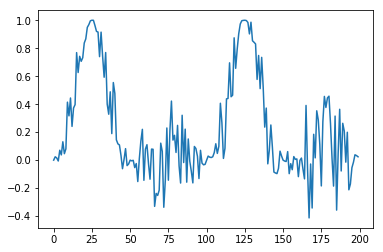

In [3]:
g = f_gen(0)
plt.plot([next(g) for _ in range(samples*2)])
plt.show()

(50, 200)


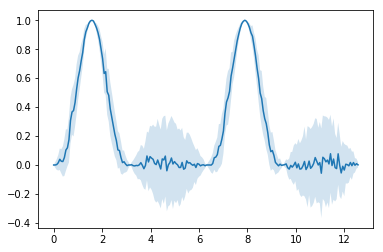

In [4]:
iters = 50
data = np.empty((0, samples*2))
x = np.linspace(0, np.pi*4, samples*2)
for i in range(iters):
    g = f_gen(0)
    y = [next(g) for _ in range(samples*2)]
    data = np.vstack([data, y])
print(data.shape)

dm = data.mean(axis=0)
ds = data.std(axis=0)
fig, ax = plt.subplots()
ax.plot(x, dm)
ax.fill_between(x, dm+ds, dm-ds, alpha=0.2)
plt.show()

In [5]:
def train_mean_gen(batch_size=32, samples=8):
    gs = [f_gen()]*batch_size
    while True:
        d = [[[next(g)] for j in range(samples+1)] for g in gs]
        x = np.array([v[:-1] for v in d])
        y = np.array([v[1:] for v in d])
        yield x, y

(1, 160, 1)


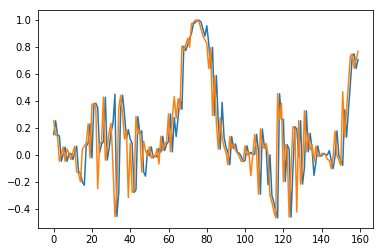

In [6]:
g = train_mean_gen(batch_size=1)
d = [next(g) for i in range(20)]
x = np.concatenate([v[0] for v in d], axis=-2)
y = np.concatenate([v[1] for v in d], axis=-2)
print(x.shape)
plt.plot(x[0])
plt.plot(y[0])
plt.show()

In [7]:
l_in = Input(shape=(None, 1))
l_lstm1 = LSTM(12, return_sequences=True, activation='tanh')(l_in)
l_out_mean = TimeDistributed(Dense(1))(l_lstm1)
l_out_var = TimeDistributed(Dense(1))(l_lstm1)

m_mean = Model(inputs=l_in, outputs=l_out_mean)
m_mean.compile(loss='mse', optimizer='adam')
print(m_mean.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 1)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 12)          672       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 1)           13        
Total params: 685
Trainable params: 685
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
# lab crashes with default verbose
m_mean.fit_generator(train_mean_gen(), steps_per_epoch=2e3, epochs=5, verbose=2)

Epoch 1/5
29s - loss: 0.0402
Epoch 2/5
27s - loss: 0.0355
Epoch 3/5
27s - loss: 0.0351
Epoch 4/5
27s - loss: 0.0349
Epoch 5/5
27s - loss: 0.0348


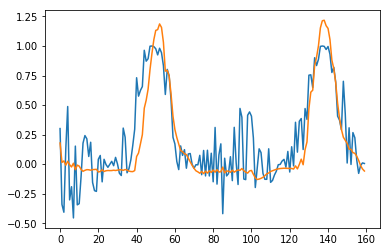

In [9]:
g = train_mean_gen(batch_size=1)
d = [next(g) for i in range(20)]
x = np.concatenate([v[0] for v in d], axis=-2)
plt.plot(x[0])
plt.plot(m_mean.predict(x)[0])
plt.show()

In [10]:
def train_var_gen(batch_size=32, samples=8):
    tg = train_mean_gen(batch_size=batch_size, samples=samples)
    while True:
        x, y = next(tg)
        p = m_mean.predict(x)
        y = np.sqrt((p - y)**2)
        yield x, y

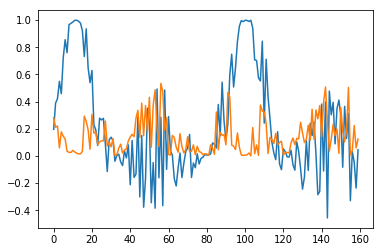

In [11]:
g = train_var_gen(batch_size=1)
d = [next(g) for i in range(20)]
x = np.concatenate([v[0] for v in d], axis=-2)
y = np.concatenate([v[1] for v in d], axis=-2)
plt.plot(x[0])
plt.plot(y[0])
plt.show()

In [12]:
m_var = Model(inputs=l_in, outputs=l_out_var)
m_var.compile(loss='mse', optimizer='adam')
print(m_var.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 1)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 12)          672       
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 1)           13        
Total params: 685
Trainable params: 685
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
m_var.fit_generator(train_var_gen(), steps_per_epoch=2e3, epochs=5, verbose=2)

Epoch 1/5
30s - loss: 0.0170
Epoch 2/5
29s - loss: 0.0182
Epoch 3/5
29s - loss: 0.0179
Epoch 4/5
29s - loss: 0.0175
Epoch 5/5
29s - loss: 0.0182


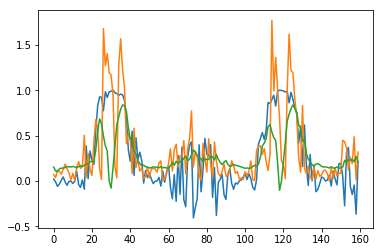

In [14]:
g = train_var_gen(batch_size=1)
d = [next(g) for i in range(20)]
x = np.concatenate([v[0] for v in d], axis=-2)
y = np.concatenate([v[1] for v in d], axis=-2)
plt.plot(x[0])
plt.plot(y[0])
plt.plot(m_var.predict(x)[0])
plt.show()

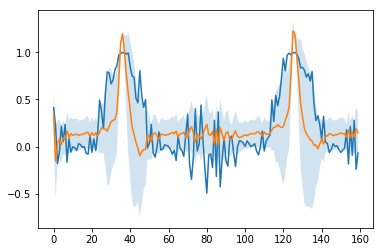

In [15]:
g = train_mean_gen(batch_size=1)
d = [next(g) for i in range(20)]
x = np.concatenate([v[0] for v in d], axis=-2)
p_mean = m_mean.predict(x)[0].flatten()
p_var = m_var.predict(x)[0].flatten()
fig, ax = plt.subplots()
ax.plot(x[0])
ax.plot(p_mean)
ax.fill_between(np.arange(p_mean.shape[0]), p_mean+p_var, p_mean-p_var, alpha=0.2)
plt.show()